In [23]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data= np.loadtxt("boston.csv",delimiter=",")

In [3]:
boston50=np.copy(data)
boston75=np.copy(data)

In [4]:
boston50[:,-1]=(boston50[:,-1]>=np.median(boston50[:,-1])).astype(int)
boston75[:,-1]=(boston75[:,-1]>=np.percentile(boston75[:,-1],75)).astype(int)

In [5]:
# Decision Tree 

In [6]:
def split_node(X,column, val):
    set_true=X[X[:,column]>=val,:]
    set_false= X[X[:,column]<val,:]
    return set_true, set_false

In [7]:
def entropy(X):
    entropy=0
    if X.shape[0]!=0: 
        for x in np.unique(X[:,-1]):
            p=float(np.sum(X[:,-1]==x))/X.shape[0]
            entropy += p * np.log2(p) 
    return -1.0 * entropy

In [8]:
class node:
    def __init__(self, col=None, val=None, is_Leaf = False, clas=None, true_branch=None, false_branch=None):
        self.col=col
        self.val=val
        self.is_Leaf = is_Leaf
        self.clas=clas
        self.true_branch=true_branch
        self.false_branch=false_branch

In [9]:
def decision_tree_node(X, m, seed):
    np.random.seed(seed)
    cols=np.random.choice(a=13,replace=False,size=m)
    np.append(cols, 13)
    entropy_X= entropy(X)
    attr, threshold, best_entropy = None, None, 1e30
    for col in cols:
        entropy_p = 0.0
        if np.unique(X[:,col]).shape[0]!=2:
            for p in [10,20,30,40,50,60,70,80,90]:
                val=np.percentile(X[:,col],p)
                set_true, set_false = split_node(X,col,val)
                entropy_true= entropy(set_true)
                entropy_false= entropy(set_false)
                entropy_p=(float(set_true.shape[0])/X.shape[0])*entropy_true +(float(set_false.shape[0])/X.shape[0])*entropy_false
                if entropy_p < best_entropy:
                    best_entropy = entropy_p
                    attr = col
                    threshold = val
        else:
            val=1.0
            set_true, set_false = split_node(X,col,val)
            entropy_true= entropy(set_true)
            entropy_false= entropy(set_false)
            entropy_p=(float(set_true.shape[0])/X.shape[0])*entropy_true + (float(set_false.shape[0])/X.shape[0])*entropy_false
            if entropy_p < best_entropy:
                best_entropy = entropy_p
                attr = col
                threshold = val
    return attr, threshold

In [10]:
def decision_tree(X,depth, max_depth, m, rec_call):
    rec_call = rec_call + 1
    if depth == max_depth:
        value, count = np.unique(X[:,-1], return_counts = True)
        return node(is_Leaf=True,clas=value[np.argmax(count)])
    attribute, threshold = decision_tree_node(X, m, rec_call)
    X_true, X_false = split_node(X, attribute, threshold)
    cur_node = node(attribute, threshold, False, -1)
    if X_true.shape[0]!=0:
        cur_node.true_branch = decision_tree(X_true, depth +1, max_depth, m, rec_call)
    if X_false.shape[0]!=0:
        cur_node.false_branch = decision_tree(X_false, depth + 1, max_depth, m, rec_call)
    return cur_node

In [11]:
def classify(X,tree):
    if tree.is_Leaf==True:
        return tree.clas
    else:
        if isinstance(X[:,tree.col][0],int) or isinstance(X[:,tree.col][0],float):
            if X[:,tree.col]>=tree.val:
                if tree.true_branch is not None:
                    return classify(X,tree.true_branch)
                if tree.true_branch is None:
                    return classify(X,tree.false_branch)
            elif X[:,tree.col]<tree.val: 
                if tree.false_branch is not None:
                    return classify(X,tree.false_branch)
                if tree.false_branch is None:
                    return classify(X,tree.true_branch)
        else:
            if X[:,tree.col]==tree.val:
                return classify(X,tree.true_branch)
            else:
                return classify(X,tree.false_branch)

In [12]:
def bootstrap_sample(X,seeed):
    np.random.seed(seeed)
    return list(np.random.choice(a=X.shape[0],size=X.shape[0], replace=True))

In [13]:
def cross_validation(X,k, m, depth, max_depth, rec_call, n):
    np.random.shuffle(X)
    index=[]
    accu=[]
    for i in range(0,k):
        index.append(range(X.shape[0]*i/k,X.shape[0]*(i+1)/k))
    for i in range(0,len(index)):
        acc=np.zeros((2,m))
        test=np.copy(X[index[i],:])
        train=np.delete(X[:,:],index[i],axis=0)
        for f in range(1,m+1):
            ys_test=np.zeros((test.shape[0],100))
            ys_train=np.zeros((train.shape[0],100))
            for j in range(0,n):
                boot_train=train[bootstrap_sample(train,rec_call),:]
                tree= decision_tree(boot_train,depth, max_depth, f, rec_call)
                rec_call+=1
                yhat_test= map(lambda x: classify(x.reshape(1,13),tree), test[:,0:13])
                yhat_train= map(lambda x: classify(x.reshape(1,13),tree), train[:,0:13])
                ys_test[:,j]=yhat_test
                ys_train[:,j]=yhat_train
            ypred_test=(np.sum(ys_test,axis=1)>=int(n/2)).astype(int)
            ypred_train=(np.sum(ys_train,axis=1)>=int(n/2)).astype(int)
            acc[0,f-1]=np.sum(np.absolute(ypred_train-train[:,-1]))/train.shape[0]
            acc[1,f-1]=np.sum(np.absolute(ypred_test-test[:,-1]))/test.shape[0]
        accu.append(acc)
    return accu


In [14]:
accu=cross_validation(boston50,10, 13, 0,2, 1, 100)

In [27]:
acc=np.array(accu).reshape((20,13))
print acc
train=acc[[0,2,4,6,8,10,12,14,16,18],:]
test=acc[[1,3,5,7,9,11,13,15,17,19],:]
np.savetxt("RF_table.csv",acc,delimiter=",")

In [16]:
print "Boston 50"
print "Train std"
print np.std(train,axis=0)
np.savetxt("train_std.csv",np.std(train,axis=0),delimiter=",")
print "Train mean"
print np.mean(train,axis=0)
np.savetxt("train_mean.csv",np.mean(train,axis=0),delimiter=",")
print "Test std"
print np.std(test,axis=0)
np.savetxt("test_std.csv",np.std(test,axis=0),delimiter=",")
print "Test mean" 
print np.mean(test,axis=0)
np.savetxt("test_mean.csv",np.mean(test,axis=0),delimiter=",")

Boston 50
Train std
[ 0.01203961  0.00619529  0.01247879  0.00924239  0.00920873  0.00610624
  0.00652056  0.00891896  0.0080819   0.00746218  0.00707075  0.01048636
  0.01264527]
Train mean
[ 0.20333815  0.18599238  0.16930499  0.15656738  0.1473448   0.14405099
  0.14448622  0.14515038  0.14603046  0.14778436  0.14163245  0.14339021
  0.14669125]
Test std
[ 0.05424912  0.05155574  0.06550292  0.0546069   0.03864558  0.03803161
  0.04395174  0.04473107  0.04725586  0.04375678  0.04157575  0.04397343
  0.0497561 ]
Test mean
[ 0.20760784  0.19988235  0.192       0.17603922  0.16619608  0.15231373
  0.15827451  0.15823529  0.15827451  0.15823529  0.14647059  0.15435294
  0.16611765]


In [17]:
accu75=cross_validation(boston75,10, 13, 0,2, 1, 100)

In [28]:
acc75=np.array(accu75).reshape((20,13))
print acc75
train75=acc75[[0,2,4,6,8,10,12,14,16,18],:]
test75=acc75[[1,3,5,7,9,11,13,15,17,19],:]
np.savetxt("RF_table_75.csv",acc75,delimiter=",")

In [34]:
print "Boston 75"
print "Train std"
print np.std(train75,axis=0)
np.savetxt("train_std.csv",np.std(train75,axis=0),delimiter=",")
print "Train mean"
print np.mean(train75,axis=0)
np.savetxt("train_mean.csv",np.mean(train75,axis=0),delimiter=",")
print "Test std"
print np.std(test75,axis=0)
np.savetxt("test_std.csv",np.std(test75,axis=0),delimiter=",")
print "Test mean" 
print np.mean(test75,axis=0)
np.savetxt("test_mean.csv",np.mean(test75,axis=0),delimiter=",")

Boston 75
Train std
[ 0.02815277  0.01152439  0.0067168   0.00338392  0.00492547  0.00424012
  0.00522929  0.00324242  0.00257802  0.00529981  0.00320678  0.00274691
  0.00396756]
Train mean
[ 0.1938958   0.11110565  0.09200887  0.08388278  0.08322778  0.0821284
  0.08388568  0.08366541  0.08080875  0.08300607  0.0823477   0.08366493
  0.08300704]
Test std
[ 0.08801808  0.04633995  0.04057376  0.03376824  0.03076422  0.035847
  0.03790478  0.02843816  0.03121798  0.0314087   0.02656234  0.02514456
  0.02803634]
Test mean
[ 0.21156863  0.11870588  0.10482353  0.09694118  0.09501961  0.09105882
  0.09305882  0.09301961  0.08905882  0.09694118  0.09290196  0.09294118
  0.09294118]


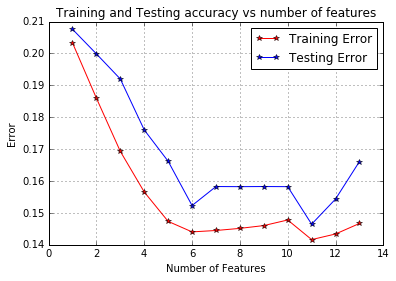

In [30]:
plt.figure()
plt.title("Training and Testing accuracy vs number of features")
plt.xlabel("Number of Features")
plt.ylabel("Error")
plt.grid()
plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13]), np.mean(train,axis=0),'*-', color="r", label="Training Error")
plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13]), np.mean(test,axis=0), '*-', color="b", label="Testing Error")
plt.legend(loc="best")
plt.savefig('Boston50_RF.jpg')
plt.show()

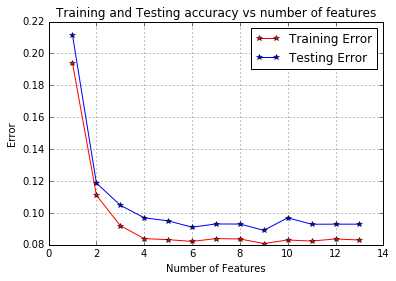

In [36]:
plt.figure()
plt.title("Training and Testing accuracy vs number of features")
plt.xlabel("Number of Features")
plt.ylabel("Error")
plt.grid()
plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13]), np.mean(train75,axis=0),'*-', color="r", label="Training Error")
plt.plot(np.array([1,2,3,4,5,6,7,8,9,10,11,12,13]), np.mean(test75,axis=0), '*-', color="b", label="Testing Error")
plt.legend(loc="best")
plt.savefig('Boston75_RF.jpg')
plt.show()